In [665]:
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from pandas.tools.plotting import scatter_matrix
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn import preprocessing
from itertools import combinations


import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Loading the data into DataFrames

In [666]:
boston = load_boston()
print(boston.data.shape)

(506, 13)


In [667]:
train_df = pd.DataFrame(boston.data, columns=boston['feature_names'])
train_df['MEDV'] = pd.DataFrame(boston.target)
train_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [668]:
y_target = train_df['MEDV']
X_features = train_df.ix[:, ~train_df.columns.isin(['MEDV'])]

# looking at the statistics of the features and the target

In [669]:
y_target.describe()

count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: MEDV, dtype: float64

In [670]:
X_features.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


# Feature Normalizations

In [671]:
## feature Normalizations ##
X_features_normalized = preprocessing.scale(X_features)
pd.DataFrame(X_features_normalized, columns=X_features.columns).head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.417713,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562
1,-0.415269,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439
2,-0.415272,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727
3,-0.414680,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517
4,-0.410409,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501


# Stacking

In [673]:
## writing a class with fit/predict/scoring method, to fit the sub-classifiers onto the data and fit
# a meta classifier on top of the base classifier and evaluate the performance
class stacked_classifier():
    def __init__(self, base_classifiers=None, meta_classifier=None):
        self.base_classifiers = base_classifiers
        self.meta_classifier = meta_classifier


    def fit(self, X, y):
        for classifier in self.base_classifiers:
            classifier.fit(X, y)
        X_meta=self.predict_base(X)
        self.meta_classifier.fit(X_meta, y)

    def predict_base(self, X):
        self.predictions = np.zeros(len(X))
        for classifier in self.base_classifiers:
            self.predictions=np.column_stack([self.predictions, classifier.predict(X)])
        return self.predictions
        
    def scoring(self,X,y):
        clf_score=[]
        for classifier in self.base_classifiers:
            #print "The score of base classifier", type(classifier), "is: ", classifier.score(X, y)
            clf_score.append(classifier.score(X, y))
        #print "The score of the final stacked classifier is: ", self.meta_classifier.score(self.predict_base(X),y)
        clf_score.append(self.meta_classifier.score(self.predict_base(X),y))
        return clf_score

# Creating sub and meta classifiers

In [674]:
DTR = DecisionTreeRegressor(random_state=0)
LR = linear_model.LinearRegression()
RR =  linear_model.Ridge(random_state=1)
LAR = linear_model.Lasso(random_state=2)
BRR =linear_model.BayesianRidge()
ETR = ExtraTreeRegressor(random_state=32)

In [675]:
X_train, X_test, y_train, y_test = train_test_split(X_features_normalized, y_target, test_size=0.2, random_state=42)

# Importing the results of all possible combinations of base+meta classifier into a DataFrame

In [676]:
def stack_scoring(clf_dict, score_df, n):
    l=0
    for clf in combinations(clf_dict,n):
        stacked_clf=stacked_classifier(base_classifiers=clf[0:n-1], meta_classifier=clf[n-1])
        stacked_clf.fit(X_train,y_train)
        clf_scores=[clf_dict.get(clf[i]) for i in range(n)]+stacked_clf.scoring(X_test,y_test)
        score_df.loc[l]= clf_scores
        l+=1
    return score_df

In [677]:
clf_dict={DTR: 'Decision Tree',LR:'Linear Regression',RR: 'Ridge',LAR: 'Lasso',BRR: 'Bayes Ridge', ETR: 'Extra Tree'}
score_df = pd.DataFrame(columns=['Base1','Base2', 'Meta','Base1 Score','Base2 Score', 'Meta Score'])

stack_2_base_score = stack_scoring(clf_dict,score_df, 3)
print "Best stacked classifier with 2 sub-classifier is: \n", stack_2_base_score.loc[stack_2_base_score['Meta Score'].idxmax()]
stack_2_base_score

Best stacked classifier with 2 sub-classifier is: 
Base1          Decision Tree
Base2             Extra Tree
Meta             Bayes Ridge
Base1 Score        0.8492683
Base2 Score        0.7285538
Meta Score         0.8618468
Name: 7, dtype: object


,Base1,Base2,Meta,Base1 Score,Base2 Score,Meta Score
0,Decision Tree,Ridge,Lasso,0.849268,0.668168,0.850557
1,Decision Tree,Ridge,Extra Tree,0.849268,0.668168,0.849524
2,Decision Tree,Ridge,Bayes Ridge,0.849268,0.668168,0.849268
3,Decision Tree,Ridge,Linear Regression,0.849268,0.668168,0.849268
4,Decision Tree,Lasso,Extra Tree,0.849268,0.624401,0.853307
5,Decision Tree,Lasso,Bayes Ridge,0.849268,0.624401,0.849268
6,Decision Tree,Lasso,Linear Regression,0.849268,0.624401,0.849268
7,Decision Tree,Extra Tree,Bayes Ridge,0.849268,0.728554,0.861847
8,Decision Tree,Extra Tree,Linear Regression,0.849268,0.728554,0.861847
9,Decision Tree,Bayes Ridge,Linear Regression,0.849268,0.666657,0.849268


In [678]:
score_df = pd.DataFrame(columns=['Base1','Base2','Base3', 'Meta','Base1 Score','Base2 Score','Base3 Score', 'Meta Score'])
stack_3_base_score= stack_scoring(clf_dict,score_df, 4)
print "Best stacked classifier with 3 sub-classifier is: \n", stack_3_base_score.loc[stack_3_base_score['Meta Score'].idxmax()]
stack_3_base_score

Best stacked classifier with 3 sub-classifier is: 
Base1              Decision Tree
Base2                      Ridge
Base3                 Extra Tree
Meta           Linear Regression
Base1 Score            0.8492683
Base2 Score            0.6681678
Base3 Score            0.7285538
Meta Score             0.8618468
Name: 4, dtype: object


,Base1,Base2,Base3,Meta,Base1 Score,Base2 Score,Base3 Score,Meta Score
0,Decision Tree,Ridge,Lasso,Extra Tree,0.849268,0.668168,0.624401,0.850148
1,Decision Tree,Ridge,Lasso,Bayes Ridge,0.849268,0.668168,0.624401,0.849268
2,Decision Tree,Ridge,Lasso,Linear Regression,0.849268,0.668168,0.624401,0.849268
3,Decision Tree,Ridge,Extra Tree,Bayes Ridge,0.849268,0.668168,0.728554,0.861799
4,Decision Tree,Ridge,Extra Tree,Linear Regression,0.849268,0.668168,0.728554,0.861847
5,Decision Tree,Ridge,Bayes Ridge,Linear Regression,0.849268,0.668168,0.666657,0.849268
6,Decision Tree,Lasso,Extra Tree,Bayes Ridge,0.849268,0.624401,0.728554,0.861843
7,Decision Tree,Lasso,Extra Tree,Linear Regression,0.849268,0.624401,0.728554,0.861847
8,Decision Tree,Lasso,Bayes Ridge,Linear Regression,0.849268,0.624401,0.666657,0.849268
9,Decision Tree,Extra Tree,Bayes Ridge,Linear Regression,0.849268,0.728554,0.666657,0.861847


# Conclusions:
- Stacking doesn't always improve the performance of a regressor/classifier and it might even hurts the performance
- The more number of base classifiers (inner classifiers) doesn't mean a better overal performance. In our example, going from 2 to 3 sub-classifier didn't help to improve the performance (and we even got better performance with only 2 sub-classifiers)

# Looking for Further Improvement by Feature Selection

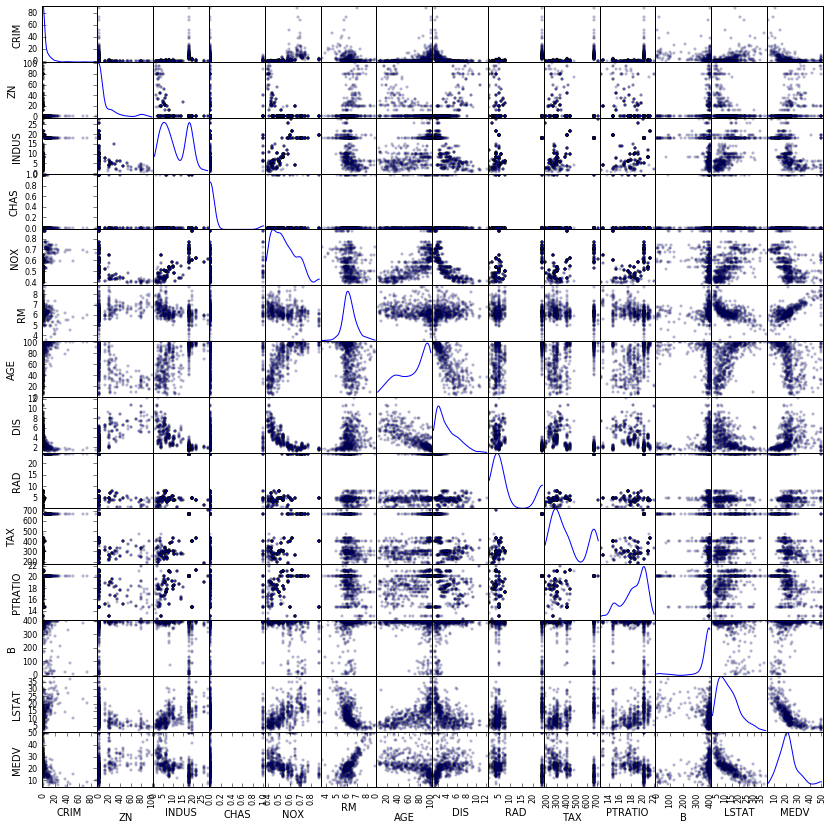

In [679]:
#plotting the scatter plots of all features and target to see if there are any strong correlation
#between features and target and among features themselves
scatter_matrix(train_df, alpha=0.2, figsize=(14, 14), diagonal='kde')
plt.show()

#### We can see from the above plots that features like (NOX, LSTAT) or (AGE, NOX) are highly correlated and can cause overfitting. We use RandomForrestRegressor to choose the best features and rerun the stacking to see if we can gain any improvement. 

In [680]:
## fitting a random forest regressor and finding the score of each feature ##
rfc.fit(X_features,y_target)
print "Feature Importance scores:", 
sorted(zip(X_features.columns, rfc.feature_importances_), key=lambda x:x[1], reverse=True)

Feature Importance scores:

[('RM', 0.45063761802773766),
 ('LSTAT', 0.3699924647948355),
 ('DIS', 0.064954983272088929),
 ('CRIM', 0.027891923940756756),
 ('NOX', 0.025373838160497465),
 ('PTRATIO', 0.019470745017946829),
 ('TAX', 0.015524985563544447),
 ('AGE', 0.0096669219106049302),
 ('B', 0.0084377341217762841),
 ('INDUS', 0.0039875062096949116),
 ('RAD', 0.0027092570463532811),
 ('ZN', 0.0010188411263805076),
 ('CHAS', 0.00033318080778250097)]

In [681]:
## Selecting the top
selected=[x[0] for x in sorted(zip(X_features.columns, rfc.feature_importances_), key=lambda x:x[1], reverse=True)][0:12]
X_features_filtered=X_features.ix[:,X_features.columns.isin(selected)]
X_features_normalized = preprocessing.scale(X_features_filtered)
X_train, X_test, y_train, y_test = train_test_split(X_features_normalized, y_target, test_size=0.2, random_state=42)

clf_dict={DTR: 'Decision Tree',LR:'Linear Regression',RR: 'Ridge',LAR: 'Lasso',BRR: 'Bayes Ridge', ETR: 'Extra Tree'}
score_df = pd.DataFrame(columns=['Base1','Base2', 'Meta','Base1 Score','Base2 Score', 'Meta Score'])

stack_2_base_score = stack_scoring(clf_dict,score_df, 3)
print "Best stacked classifier with 2 sub-classifier is: \n", stack_2_base_score.loc[stack_2_base_score['Meta Score'].idxmax()]
stack_2_base_score

Best stacked classifier with 2 sub-classifier is: 
Base1          Decision Tree
Base2             Extra Tree
Meta             Bayes Ridge
Base1 Score        0.8409635
Base2 Score        0.7271969
Meta Score         0.8875087
Name: 7, dtype: object


,Base1,Base2,Meta,Base1 Score,Base2 Score,Meta Score
0,Decision Tree,Ridge,Lasso,0.840964,0.663471,0.842286
1,Decision Tree,Ridge,Extra Tree,0.840964,0.663471,0.840700
2,Decision Tree,Ridge,Bayes Ridge,0.840964,0.663471,0.840964
3,Decision Tree,Ridge,Linear Regression,0.840964,0.663471,0.840964
4,Decision Tree,Lasso,Extra Tree,0.840964,0.623552,0.842333
5,Decision Tree,Lasso,Bayes Ridge,0.840964,0.623552,0.840964
6,Decision Tree,Lasso,Linear Regression,0.840964,0.623552,0.840964
7,Decision Tree,Extra Tree,Bayes Ridge,0.840964,0.727197,0.887509
8,Decision Tree,Extra Tree,Linear Regression,0.840964,0.727197,0.887509
9,Decision Tree,Bayes Ridge,Linear Regression,0.840964,0.662132,0.840964


# Conclusions:
we can see that limiting the number of features and choosing the best features based on their score improve the performance by 2% compared to the performance (score of 88%) on the full set of the features (score of 86%).